This script is made to analyze critical point in order to improve order managment       

In [1]:
#library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

**Dataframe creation**

In [2]:
#upload and dataset visualization
df_order = pd.read_csv('orders_cleaned.csv')
df_order_items = pd.read_csv('order_items_cleaned.csv')
df_user = pd.read_csv('users_cleaned2.csv')
df_product = pd.read_csv('products_cleaned.csv')

In [3]:
#merging df_order_items with df_order_items
df_order_status = df_order_items.merge(df_order.drop(columns=['gender']), on=['order_id','user_id'], how='left')

In [4]:
#df_order_status_user
df_order_status_user = df_order_status.merge(df_user.drop(columns=['user_geom']), on='user_id', how='left')

In [5]:
#df cleaning
df_order_status_user['country'] = df_order_status_user['country'].replace({'España': 'Spain'})

In [6]:
#change columns name
df_order_status_user['order_item_created_at'] = df_order_status_user['created_at_x']
df_order_status_user['user_created_at'] = df_order_status_user['created_at_y']
df_order_status_user = df_order_status_user.drop(columns=['created_at_x', 'created_at_y'])

In [7]:
#change colum data type
date_cols = [
    'order_item_created_at', 'shipped_at', 'delivered_at', 'returned_at',
    'order_created_at', 'order_shipped_at', 'order_delivered_at', 'order_returned_at',
    'user_created_at'
]
df_order_status_user[date_cols] = df_order_status_user[date_cols].apply(pd.to_datetime)

In [8]:
#operative time
date_cols = [
    'order_item_created_at', 'shipped_at', 'delivered_at', 'returned_at',
    'order_created_at', 'order_shipped_at', 'order_delivered_at', 'order_returned_at'
]
df_order_status_user[date_cols] = df_order_status_user[date_cols].apply(pd.to_datetime)

In [9]:
#order time by items
df_order_status_user['t_order_to_item'] = df_order_status_user['order_item_created_at'] - df_order_status_user['order_created_at']
#shipping time
df_order_status_user['t_item_to_ship'] = df_order_status_user['shipped_at'] - df_order_status_user['order_item_created_at']
#delivery time
df_order_status_user['t_ship_to_delivery'] = df_order_status_user['delivered_at'] - df_order_status_user['shipped_at']
#return time
df_order_status_user['t_delivery_to_return'] = df_order_status_user['returned_at'] - df_order_status_user['delivered_at']

In [10]:
#colums conversion in days
df_order_status_user['t_order_to_item_days'] = df_order_status_user['t_order_to_item'] / pd.Timedelta(days=1)
df_order_status_user['t_item_to_ship_days'] = df_order_status_user['t_item_to_ship'] / pd.Timedelta(days=1)
df_order_status_user['t_ship_to_delivery_days'] = df_order_status_user['t_ship_to_delivery'] / pd.Timedelta(days=1)
df_order_status_user['t_delivery_to_return_days'] = df_order_status_user['t_delivery_to_return'] / pd.Timedelta(days=1)

In [11]:
#Negative values removing
df_order_status_user['t_order_to_item_days'] = df_order_status_user['t_order_to_item_days'].mask(
    df_order_status_user['t_order_to_item_days'] < 0, 
    np.nan
)

df_order_status_user['t_item_to_ship_days'] = df_order_status_user['t_item_to_ship_days'].mask(
    df_order_status_user['t_item_to_ship_days'] < 0, 
    np.nan
)

df_order_status_user['t_ship_to_delivery_days'] = df_order_status_user['t_ship_to_delivery_days'].mask(
    df_order_status_user['t_ship_to_delivery_days'] < 0, 
    np.nan
)

df_order_status_user['t_delivery_to_return_days'] = df_order_status_user['t_delivery_to_return_days'].mask(
    df_order_status_user['t_delivery_to_return_days'] < 0, 
    np.nan
)

In [12]:
#age groups
bins = [15, 26, 37, 48, 59, 71]
labels = ['16-25','26-36','37-47','48-58','59-70']
df_order_status_user['age_group'] = pd.cut(df_order_status_user['age'], bins=bins, labels=labels)

In [13]:
df_order_status_user2 = df_order_status_user.drop_duplicates(subset=['order_id'])
df_order_status_user['year'] = df_order_status_user['order_created_at'].dt.to_period('Y')
df_order_status_user['year_month'] = df_order_status_user['order_created_at'].dt.to_period('M')

In [14]:
print(df_order_status_user.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180910 entries, 0 to 180909
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype          
---  ------                     --------------   -----          
 0   order_id                   180910 non-null  int64          
 1   user_id                    180910 non-null  int64          
 2   product_id                 180910 non-null  int64          
 3   inventory_item_id          180910 non-null  int64          
 4   items_status               180910 non-null  object         
 5   shipped_at                 117492 non-null  datetime64[ns] 
 6   delivered_at               63109 non-null   datetime64[ns] 
 7   returned_at                17961 non-null   datetime64[ns] 
 8   sale_price                 180910 non-null  float64        
 9   order_status               180910 non-null  object         
 10  order_created_at           180910 non-null  datetime64[ns] 
 11  order_returned_at          17961 non-nu

In [15]:
print(df_order_status_user2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 124869 entries, 0 to 180908
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype          
---  ------                     --------------   -----          
 0   order_id                   124869 non-null  int64          
 1   user_id                    124869 non-null  int64          
 2   product_id                 124869 non-null  int64          
 3   inventory_item_id          124869 non-null  int64          
 4   items_status               124869 non-null  object         
 5   shipped_at                 81019 non-null   datetime64[ns] 
 6   delivered_at               43485 non-null   datetime64[ns] 
 7   returned_at                12459 non-null   datetime64[ns] 
 8   sale_price                 124869 non-null  float64        
 9   order_status               124869 non-null  object         
 10  order_created_at           124869 non-null  datetime64[ns] 
 11  order_returned_at          12459 non-null   

**Consumer profile analyses**

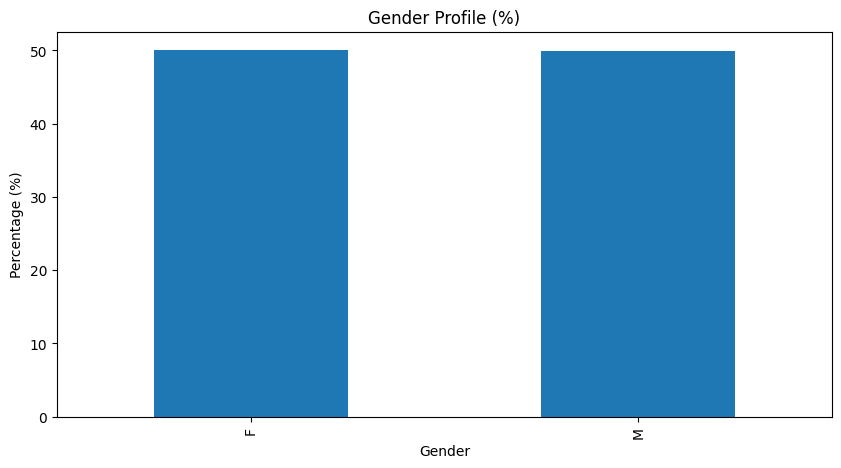

Gender profile:
gender
F    50.05%
M    49.95%
Name: proportion, dtype: object


In [16]:
# Gender profile (%)
gender_profile = df_order_status_user2['gender'].value_counts(normalize=True) * 100

# Plot (numeri, non stringhe)
gender_profile.plot(kind='bar', figsize=(10,5))
plt.title("Gender Profile (%)")
plt.xlabel("Gender")
plt.ylabel("Percentage (%)")
plt.show()

# Print sorted values (formattati come stringhe)
print("Gender profile:")
print(gender_profile.sort_values(ascending=False).round(2).astype(str) + "%")

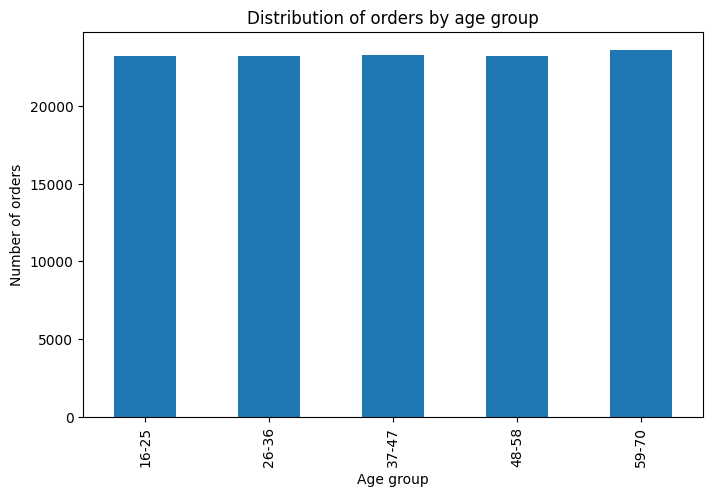

age_group
16-25    33378
26-36    33692
37-47    33593
48-58    33788
59-70    34378
Name: count, dtype: int64
age_group
16-25    19.77%
26-36    19.96%
37-47    19.90%
48-58    20.01%
59-70    20.36%
Name: proportion, dtype: object


In [17]:
#age group distribution
df_order_status_user2['age_group'].value_counts().sort_index().plot(kind='bar', figsize=(8,5))

plt.title("Distribution of orders by age group")
plt.xlabel("Age group")
plt.ylabel("Number of orders")
plt.show()  

print(df_order_status_user['age_group'].value_counts().sort_index())
print(df_order_status_user['age_group'].value_counts(normalize=True).sort_index().mul(100).round(2).apply(lambda x: f"{x:.2f}%"))

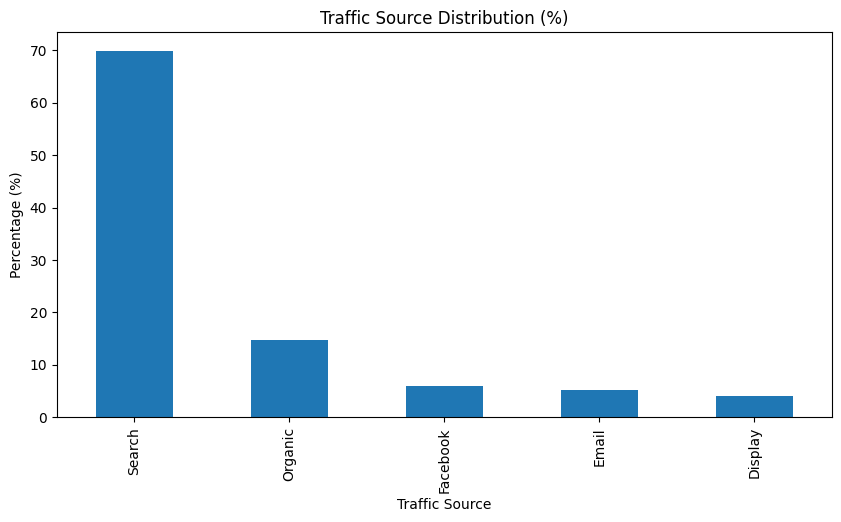

Traffic source distribution (sorted):
traffic_source
Search      69.95
Organic     14.78
Facebook     6.04
Email        5.12
Display      4.10
Name: proportion, dtype: float64


In [18]:
# Traffic source distribution (%)
traffic_source = (df_order_status_user2['traffic_source'].value_counts(normalize=True) * 100)

traffic_source.plot(kind='bar', figsize=(10,5))
plt.title("Traffic Source Distribution (%)")
plt.xlabel("Traffic Source")
plt.ylabel("Percentage (%)")
plt.show()

# Print sorted values
print("Traffic source distribution (sorted):")
print(traffic_source.round(2))

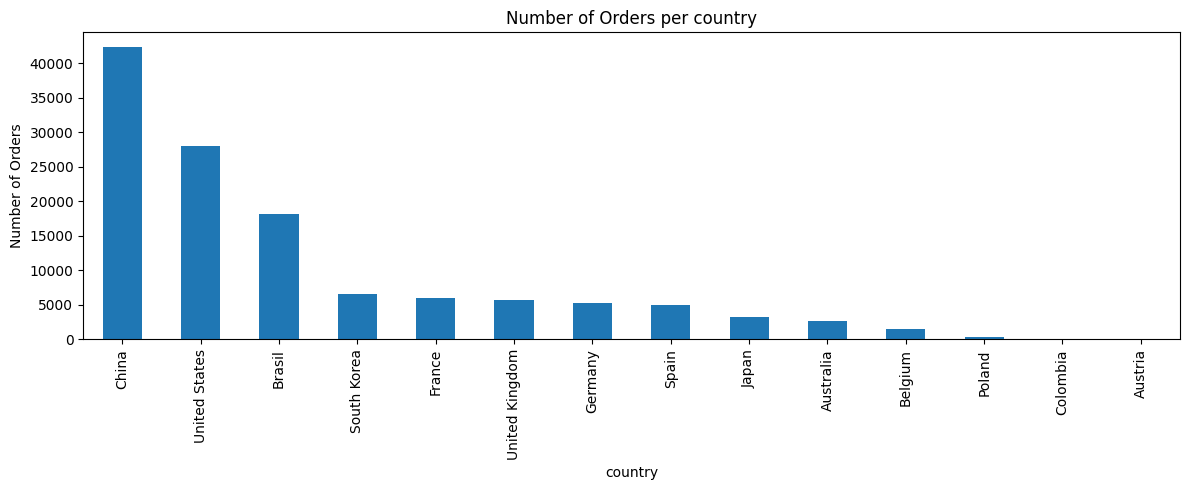

countrys generating the highest number of orders:
country
China            42367
United States    27970
Brasil           18224
South Korea       6604
France            5921
Name: order_id, dtype: int64

countrys generating the lowest number of orders:
country
Austria         5
Colombia       14
Poland        288
Belgium      1471
Australia    2704
Name: order_id, dtype: int64


In [19]:
#orders geography by country
orders_by_country = (df_order_status_user2.groupby('country')['order_id'].nunique().sort_values(ascending=False))

orders_by_country.plot(kind='bar', figsize=(12,5))
plt.title("Number of Orders per country")
plt.xlabel("country")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()

print("countrys generating the highest number of orders:")
print((orders_by_country).sort_values(ascending=False).head())

print("\ncountrys generating the lowest number of orders:")
print((orders_by_country).sort_values(ascending=True).head())

In [20]:
#orders geography by states
orders_by_state = df_order_status_user2.groupby('state')['order_id'].nunique().sort_values(ascending=False)
print("state generarte highest revenue:")
print((orders_by_state).sort_values(ascending=False).head())
print("\nstate generarte lowest  revenue:")
print((orders_by_state).sort_values(ascending=True).head())

state generarte highest revenue:
state
Guangdong     6538
England       5088
California    4485
Texas         2921
Shanghai      2902
Name: order_id, dtype: int64

state generarte lowest  revenue:
state
Nara        1
Kagawa      2
Nagasaki    2
Iwate       2
Vermont     2
Name: order_id, dtype: int64


In [21]:
#orders geography by city
orders_by_city = df_order_status_user2.groupby('city')['order_id'].nunique().sort_values(ascending=False)
print("city generarte highest revenue:")
print((orders_by_city).sort_values(ascending=False).head())
print("\ncity generarte lowest  revenue:")
print((orders_by_city).sort_values(ascending=True).head())

city generarte highest revenue:
city
Shanghai    3003
Beijing     2537
Seoul       1821
Shenzhen    1624
Dongguan    1215
Name: order_id, dtype: int64

city generarte lowest  revenue:
city
Tega Cay        1
Habsheim        1
Haguenau        1
Haacht          1
Herk-de-Stad    1
Name: order_id, dtype: int64


In [22]:
# Frequency
total_orders = df_order_status_user2['order_id'].nunique()
total_users = df_order_status_user2['user_id'].nunique()

lifetime_frequency = total_orders / total_users

print(f"mean historical frequency: {lifetime_frequency:.2f} orders/user")

mean historical frequency: 1.56 orders/user


In [23]:
# Retention
user_order_counts = df_order_status_user2.groupby('user_id')['order_id'].nunique()

total_users = len(user_order_counts)
returning_users = len(user_order_counts[user_order_counts > 1])
retention_rate = (returning_users / total_users) * 100

print(f"Retention Rate: {retention_rate:.2f}% ({returning_users} costumers on {total_users})")

Retention Rate: 37.49% (29979 costumers on 79973)


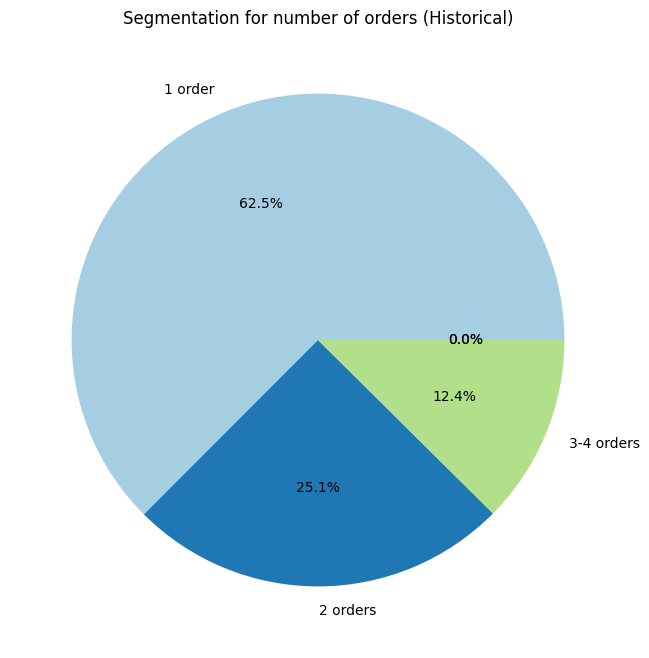

Analisis on 79973 total users:
Loyal costumer(2+ orders): 29979 (37.49%)
Casual costuers (1 order): 49994


In [24]:
#Segmentation for number of orders (Historical)
user_orders = df_order_status_user2.groupby('user_id')['order_id'].nunique() 

total_customers = len(user_orders)
loyal_customers = (user_orders > 1).sum()
one_time_customers = (user_orders == 1).sum()

retention_rate_total = (loyal_customers / total_customers) * 100

bins = [1, 2, 3, 5, 10, 50]
labels = ['1 order', '2 orders', '3-4 orders', '5-9 orders', '10+ orders']
user_segments = pd.cut(user_orders, bins=bins, labels=labels, right=False).value_counts().sort_index()

user_segments.plot(kind='pie', autopct='%1.1f%%', figsize=(8,8), colors=plt.cm.Paired.colors)
plt.title("Segmentation for number of orders (Historical)")
plt.ylabel("")
plt.show()

print(f"Analisis on {total_customers} total users:")

print(f"Loyal costumer(2+ orders): {loyal_customers} ({retention_rate_total:.2f}%)")
print(f"Casual costuers (1 order): {one_time_customers}") 

**Order analysis**

**Order state**

In [25]:
# Complete rate
order_complete_rate = df_order_status_user2['order_status'].eq('Complete').mean()
print(f"Order complete rate: {order_complete_rate:.2%}")

# Processing rate
order_processing_rate = df_order_status_user2['order_status'].eq('Processing').mean()
print(f"Order processing rate: {order_processing_rate:.2%}")

# Returned rate
order_returned_rate = df_order_status_user2['order_status'].eq('Returned').mean()
print(f"Order returned rate: {order_returned_rate:.2%}")

# Cancellation rate
order_cancel_rate = df_order_status_user2['order_status'].eq('Cancelled').mean()
print(f"Order cancellation rate: {order_cancel_rate:.2%}")

# Shipped rate
order_shipped_rate = df_order_status_user2['order_status'].eq('Shipped').mean()
print(f"Order shipped rate: {order_shipped_rate:.2%}")


Order complete rate: 24.85%
Order processing rate: 19.95%
Order returned rate: 9.98%
Order cancellation rate: 15.17%
Order shipped rate: 30.06%


Shipping time

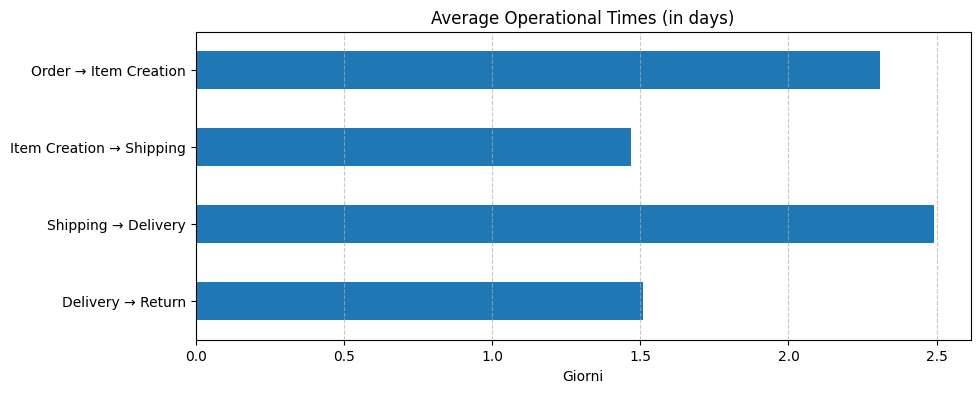


Average Operational Times (in days)
                          Average Days
Order → Item Creation             2.31
Item Creation → Shipping          1.47
Shipping → Delivery               2.49
Delivery → Return                 1.51


In [26]:
#operative time
operative_means = (
    df_order_status_user[
        ['t_order_to_item_days',
         't_item_to_ship_days',
         't_ship_to_delivery_days',
         't_delivery_to_return_days']
    ]
    .mean()
    .round(2)
)
labels = {
    't_order_to_item_days': 'Order → Item Creation',
    't_item_to_ship_days': 'Item Creation → Shipping',
    't_ship_to_delivery_days': 'Shipping → Delivery',
    't_delivery_to_return_days': 'Delivery → Return'
}
operative_means_named = operative_means.rename(index=labels)


operative_means_named.plot(kind='barh', figsize=(10, 4))

plt.gca().invert_yaxis() 
plt.title("Average Operational Times (in days)")
plt.xlabel("Giorni")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("\nAverage Operational Times (in days)")
print(operative_means_named.to_frame('Average Days'))

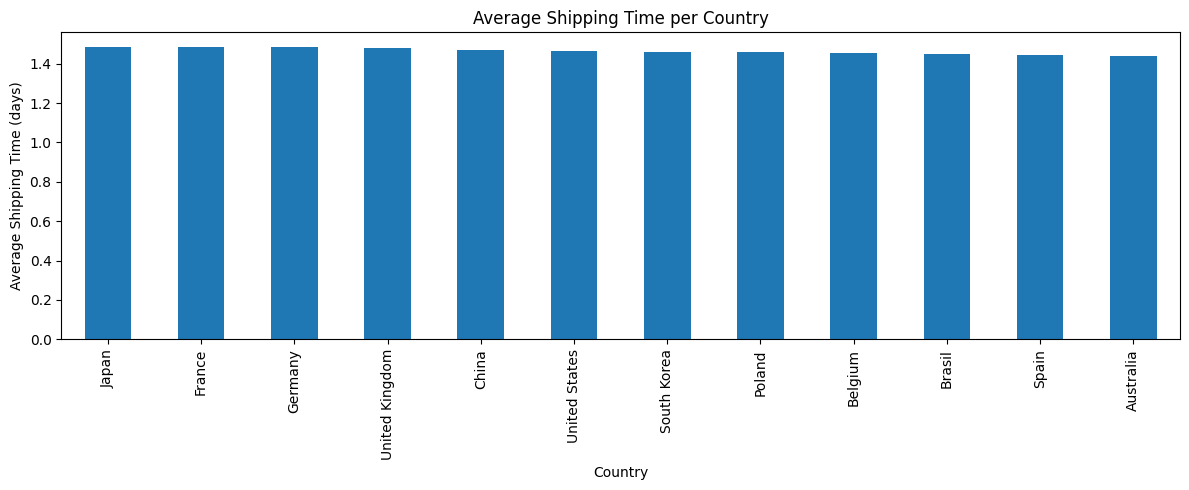

Countries with the highest average shipping time:
country
Japan             1.485322
France            1.485015
Germany           1.484015
United Kingdom    1.478511
China             1.468775
Name: t_item_to_ship_days, dtype: float64

Countries with the lowest average shipping time:
country
Australia    1.438072
Spain        1.444527
Brasil       1.447527
Belgium      1.452249
Poland       1.459769
Name: t_item_to_ship_days, dtype: float64


In [27]:
# Shipping time by country (only countries with at least 25 orders)
ship_time_country = (df_order_status_user.groupby('country')['t_item_to_ship_days'].mean().dropna().sort_values(ascending=False))

country_counts = df_order_status_user['country'].value_counts()
valid_countries = country_counts[country_counts >= 25].index

ship_time_country = (df_order_status_user[df_order_status_user['country'].isin(valid_countries)]
                    .groupby('country')['t_item_to_ship_days'].mean().dropna().sort_values(ascending=False))

ship_time_country.plot(kind='bar', figsize=(12,5))
plt.title("Average Shipping Time per Country")
plt.xlabel("Country")
plt.ylabel("Average Shipping Time (days)")
plt.tight_layout()
plt.show()

print("Countries with the highest average shipping time:")
print((ship_time_country).sort_values(ascending=False).head())

print("\nCountries with the lowest average shipping time:")
print((ship_time_country).sort_values(ascending=True).head())

In [28]:
delay_city = (df_order_status_user.groupby('city')['t_order_to_item_days'].mean())

delay_city_clean = delay_city.dropna().sort_values(ascending=False)

city_counts = df_order_status_user['city'].value_counts()
valid_cities = city_counts[city_counts >= 20].index

delay_city_clean = (
    df_order_status_user[df_order_status_user['city'].isin(valid_cities)]
    .groupby('city')['t_order_to_item_days']
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

print("Cities with the highest average order-to-item time (days):")
print(delay_city_clean.head())

print("\nCities with the lowest average order-to-item time (days):")
print(delay_city_clean.sort_values(ascending=True).head())

Cities with the highest average order-to-item time (days):
city
Biguaçu                   3.583187
Torremolinos              3.310157
Santa Maria da Vitória    3.251603
Ubatuba                   3.210160
Newtownards               3.197066
Name: t_order_to_item_days, dtype: float64

Cities with the lowest average order-to-item time (days):
city
East Kilbride       1.103025
Highland Village    1.105979
Kojima City         1.174774
Compton             1.180138
Valenciennes        1.296725
Name: t_order_to_item_days, dtype: float64


**Price statistics**

In [29]:
#Price statistics
price_distribution = df_order_status_user.groupby('country')['sale_price'].describe()
print("Country descriptive statistics:")
print(price_distribution)

Country descriptive statistics:
                  count       mean        std    min        25%        50%  \
country                                                                      
Australia        4008.0  59.579249  68.732118   0.49  24.500000  39.990002   
Austria             7.0  35.774286  25.298340  12.22  22.000000  29.209999   
Belgium          2061.0  59.949263  62.512760   2.99  24.990000  40.160000   
Brasil          26329.0  59.272689  66.517232   0.49  24.000000  39.990002   
China           61776.0  59.254614  65.548953   0.02  24.950001  39.990002   
Colombia           20.0  33.508000  29.446744   8.27  19.497500  24.750000   
France           8598.0  58.710913  64.271036   0.02  24.950001  39.990002   
Germany          7682.0  60.189606  67.792057   0.02  24.000000  39.980000   
Japan            4654.0  59.812888  62.716336   1.95  24.950001  40.000000   
Poland            443.0  56.559910  57.854295   3.75  24.000000  37.500000   
South Korea      9584.0  60.0276

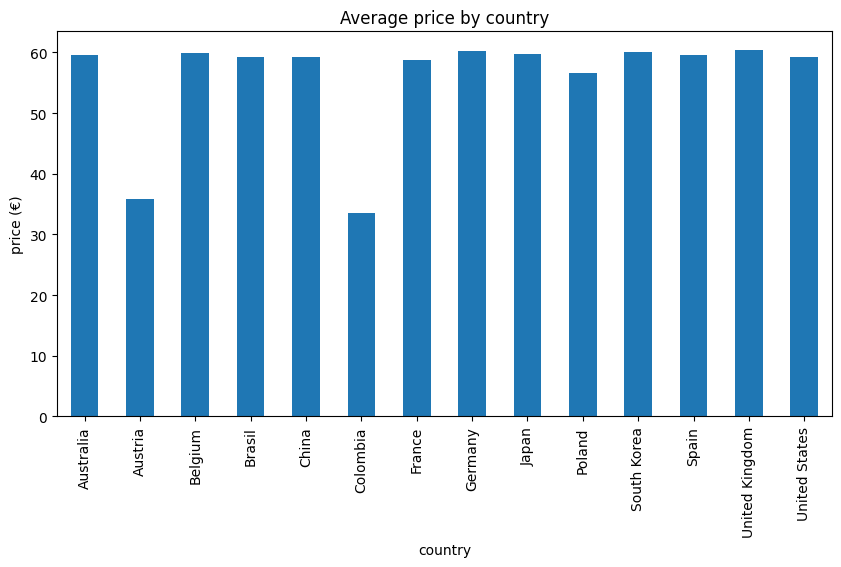

Average price by country print(avg_price_by_country):
country
Australia         59.579249
Austria           35.774286
Belgium           59.949263
Brasil            59.272689
China             59.254614
Colombia          33.508000
France            58.710913
Germany           60.189606
Japan             59.812888
Poland            56.559910
South Korea       60.027666
Spain             59.565864
United Kingdom    60.463229
United States     59.302743
Name: sale_price, dtype: float64


In [30]:
#average price per country 
avg_price_by_country = df_order_status_user.groupby('country')['sale_price'].mean()

(avg_price_by_country).plot(kind='bar', figsize=(10,5))
plt.title("Average price by country")
plt.xlabel("country")
plt.ylabel("price (€)")
plt.show()

print("Average price by country print(avg_price_by_country):")
print(avg_price_by_country)

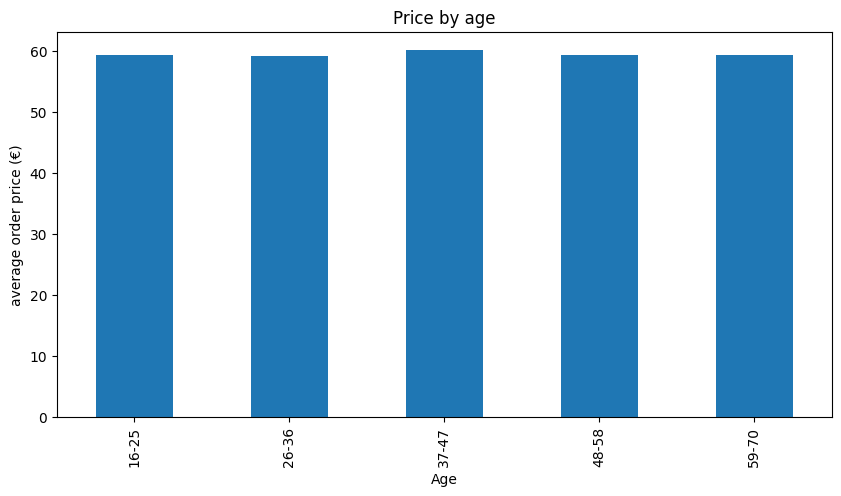

Price per Age Group (€):
age_group
16-25    59.38
26-36    59.15
37-47    60.15
48-58    59.40
59-70    59.34
Name: sale_price, dtype: float64


In [31]:
#price by age
price_by_age = (df_order_status_user.groupby(['age_group','order_id'] , observed=True)['sale_price']
                 .mean().groupby('age_group', observed=True).mean().round(2))

price_by_age.plot(kind='bar', figsize=(10,5))
plt.title("Price by age")
plt.xlabel("Age")
plt.ylabel("average order price (€)")
plt.show()
print("Price per Age Group (€):")
print(price_by_age)

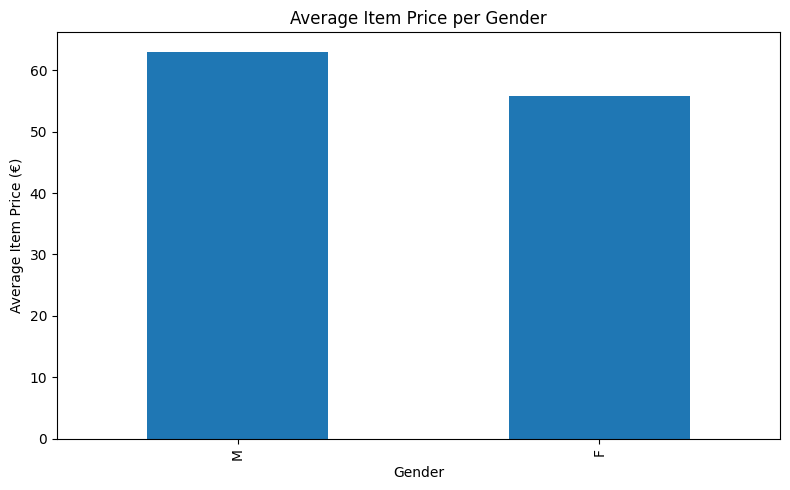

Average Item Price per Gender:
gender
M    63.01
F    55.82
Name: sale_price, dtype: float64


In [32]:
#average item price by gender
average_item_price_by_gender = (df_order_status_user.groupby('gender')['sale_price'].mean().round(2).sort_values(ascending=False))

average_item_price_by_gender.plot(kind='bar', figsize=(8,5))
plt.title("Average Item Price per Gender")
plt.xlabel("Gender")
plt.ylabel("Average Item Price (€)")
plt.tight_layout()
plt.show()


print("Average Item Price per Gender:")
print(average_item_price_by_gender)

**Revenue statistics**

In [33]:
#total revenue
total_revenue = df_order_status_user['sale_price'].sum().round(2)
print("Total Revenue:", total_revenue, "€")

Total Revenue: 10747878.64 €


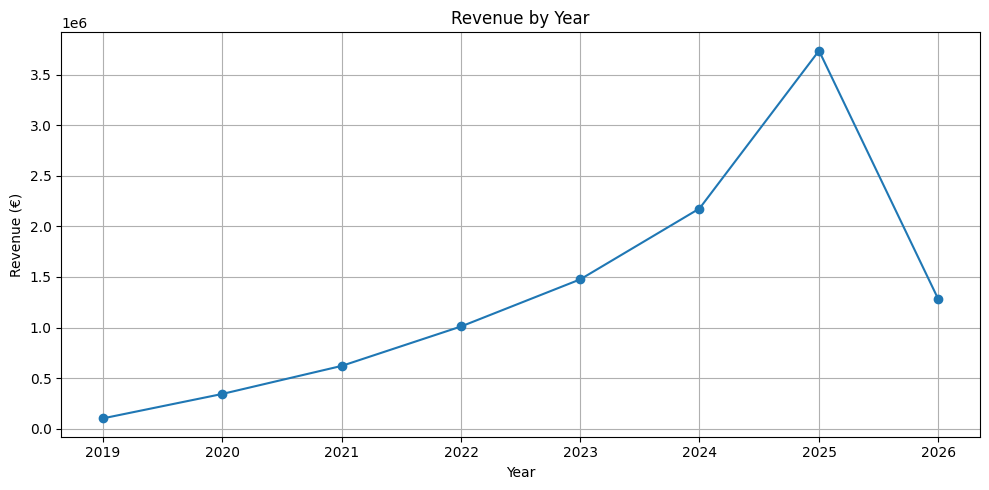

year
2019    1.026511e+05
2020    3.436682e+05
2021    6.212021e+05
2022    1.010582e+06
2023    1.476247e+06
2024    2.176316e+06
2025    3.736049e+06
2026    1.281163e+06
Freq: Y-DEC, Name: sale_price, dtype: float64


In [34]:
# Revenue per year
revenue_by_year = (df_order_status_user.groupby('year')['sale_price'].sum())

plt.figure(figsize=(10,5))
plt.plot(revenue_by_year.index.to_timestamp(), revenue_by_year.values, marker='o')
plt.title("Revenue by Year")
plt.xlabel("Year")
plt.ylabel("Revenue (€)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(revenue_by_year)

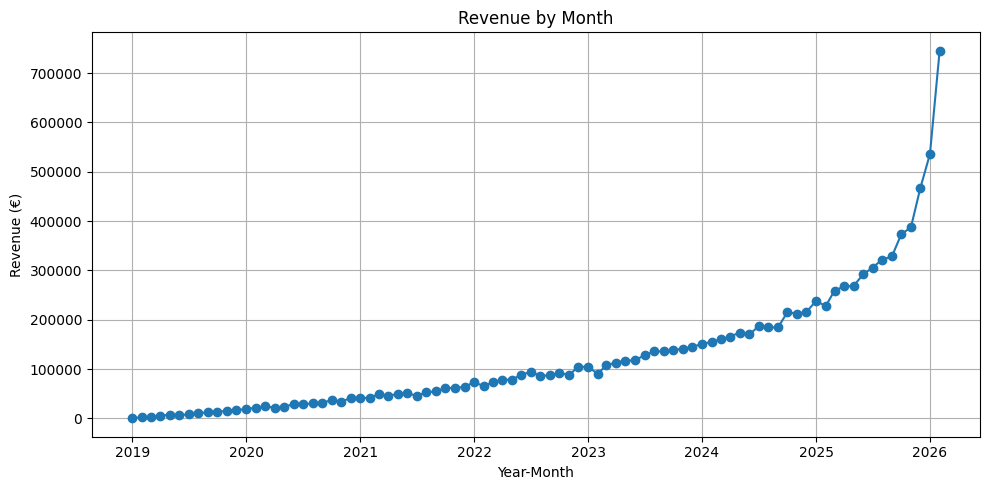

In [35]:
#revenue by month
revenue_by_month = (df_order_status_user.groupby('year_month')['sale_price'].sum())

plt.figure(figsize=(10,5))
plt.plot(revenue_by_month.index.to_timestamp(), revenue_by_month.values, marker='o')
plt.title("Revenue by Month")
plt.xlabel("Year-Month")
plt.ylabel("Revenue (€)")
plt.grid(True)
plt.tight_layout()
plt.show()

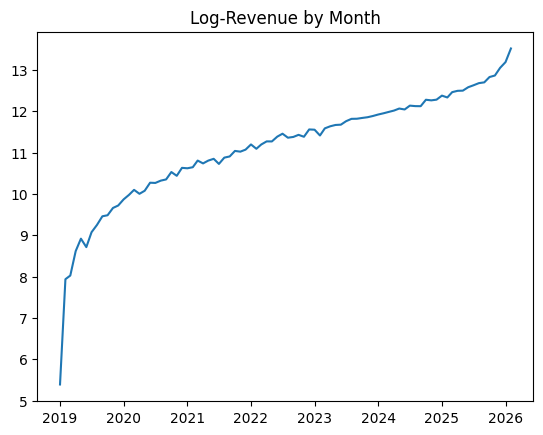

In [36]:
#logaritmic transformation
plt.plot(revenue_by_month.index.to_timestamp(), np.log(revenue_by_month.values))
plt.title("Log-Revenue by Month")
plt.show()

In [37]:
#linear regression on logaritmic trasformation on revenue by month

df_model = df_order_status_user[
    (df_order_status_user['order_created_at'].dt.year >= 2020) &
    (df_order_status_user['order_created_at'].dt.year <= 2025)
].copy()

df_model['year_month'] = df_model['order_created_at'].dt.to_period('M')
df_model['t'] = df_model['year_month'].apply(lambda x: x.to_timestamp()).astype('int64') // 10**9


rev = df_model.groupby('year_month')['sale_price'].sum().reset_index()
rev['t'] = rev['year_month'].apply(lambda x: x.to_timestamp()).astype('int64') // 10**9
rev['log_rev'] = np.log(rev['sale_price'])

X = sm.add_constant(rev['t'])
model = sm.OLS(rev['log_rev'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_rev   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     5310.
Date:                Thu, 26 Feb 2026   Prob (F-statistic):           9.61e-68
Time:                        10:59:03   Log-Likelihood:                 69.774
No. Observations:                  72   AIC:                            -135.5
Df Residuals:                      70   BIC:                            -131.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.9747      0.336    -38.646      0.0

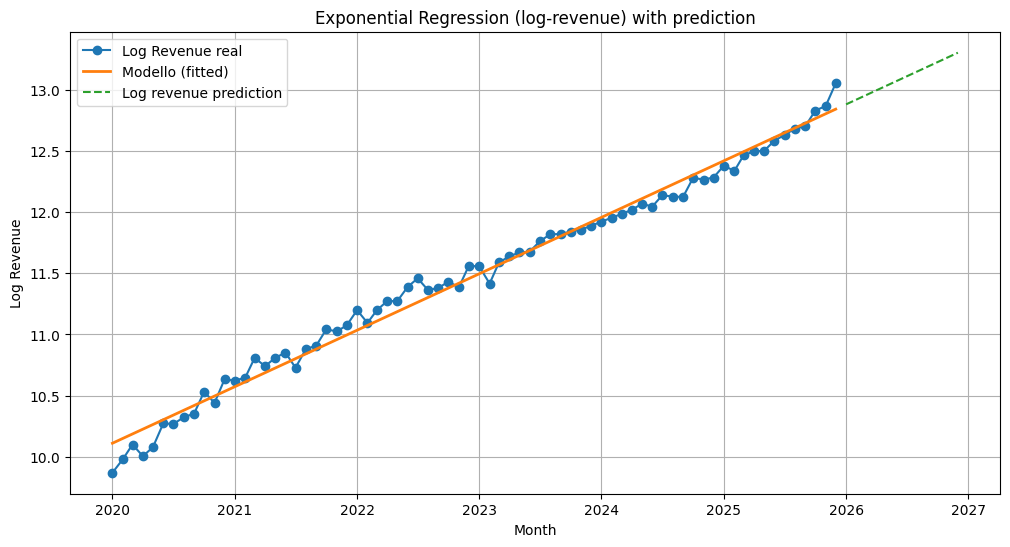

In [38]:
#graph of linear regression on logaritmic trasformation on revenue by month 
model = sm.OLS(rev['log_rev'], X).fit()
rev['fitted_log'] = model.predict(X)
last_period = rev['year_month'].max()
future_periods = pd.period_range(start=last_period+1, periods=12, freq='M')

future_df = pd.DataFrame({'year_month': future_periods})

future_df['t'] = future_df['year_month'].apply(lambda x: x.to_timestamp()).astype('int64') // 10**9
future_df['log_pred'] = model.predict(sm.add_constant(future_df['t']))

plt.figure(figsize=(12,6))

plt.plot(rev['year_month'].dt.to_timestamp(), rev['log_rev'], label='Log Revenue real', marker='o')
plt.plot(rev['year_month'].dt.to_timestamp(), rev['fitted_log'], label='Modello (fitted)', linewidth=2)

plt.plot(future_df['year_month'].dt.to_timestamp(), future_df['log_pred'], 
         label='Log revenue prediction', linestyle='--')

plt.title("Exponential Regression (log-revenue) with prediction")
plt.xlabel("Month")
plt.ylabel("Log Revenue")
plt.legend()
plt.grid(True)
plt.show()

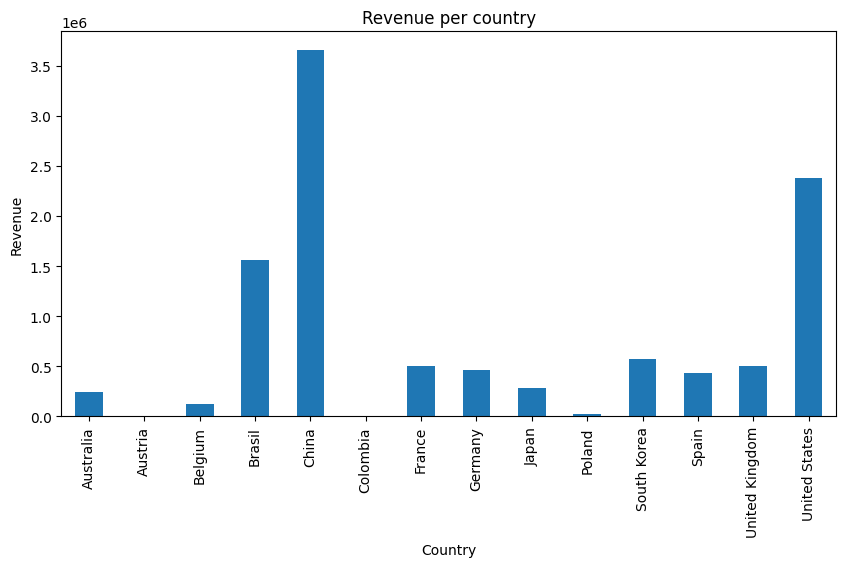

Country with highest revenue(€):
country
China            3.660513e+06
United States    2.378989e+06
Brasil           1.560591e+06
South Korea      5.753052e+05
France           5.047964e+05
Name: sale_price, dtype: float64

Country with lowest revenue(€):
country
Austria         250.420001
Colombia        670.160005
Poland        25056.040005
Belgium      123555.430175
Australia    238793.630249
Name: sale_price, dtype: float64


In [39]:
#revenue per country
rev_country = df_order_status_user.groupby('country')['sale_price'].sum()

(rev_country).plot(kind='bar', figsize=(10,5))
plt.title("Revenue per country")
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.show()

print("Country with highest revenue(€):")
print((rev_country).sort_values(ascending=False).head())
print("\nCountry with lowest revenue(€):")
print((rev_country).sort_values(ascending=True).head())

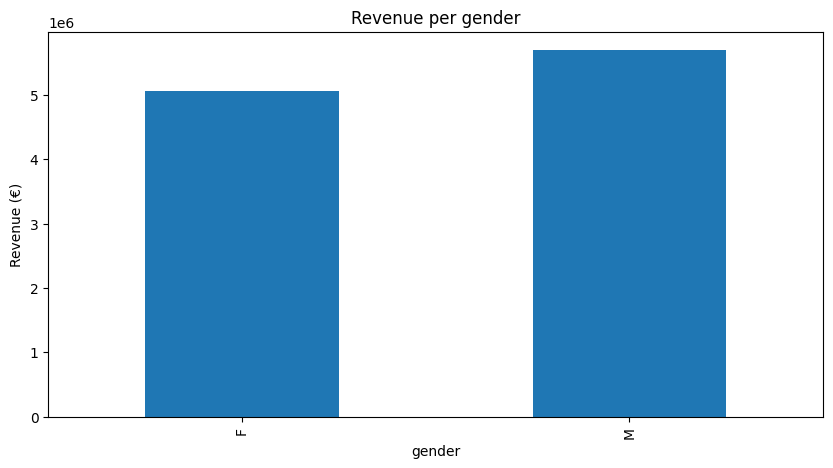

gender with highest revenue (€):
gender
F    5.052910e+06
M    5.694969e+06
Name: sale_price, dtype: float64


In [40]:
#revenue per gender
rev_gender  = df_order_status_user.groupby('gender')['sale_price'].sum()

(rev_gender).plot(kind='bar', figsize=(10,5))
plt.title("Revenue per gender")
plt.xlabel("gender")
plt.ylabel("Revenue (€)")
plt.show()

print("gender with highest revenue (€):")
print(rev_gender)

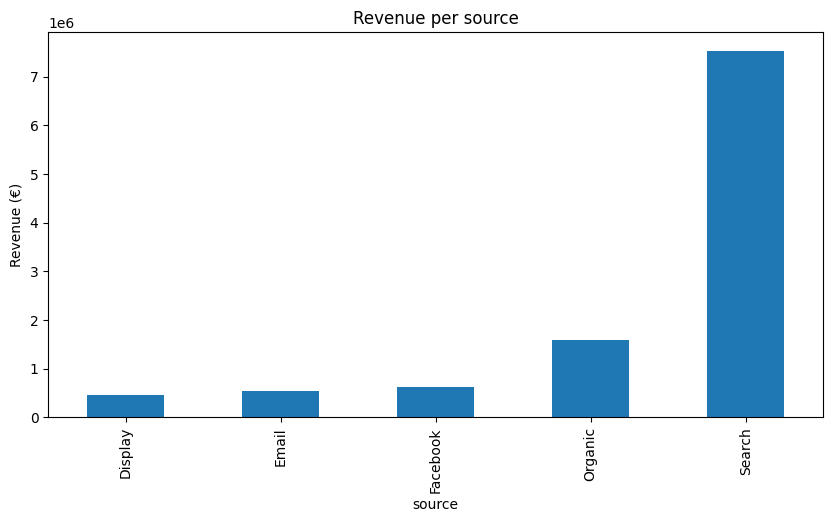

source with highest revenue (€):
traffic_source
Search      7.537615e+06
Organic     1.593920e+06
Facebook    6.293354e+05
Email       5.392447e+05
Display     4.477640e+05
Name: sale_price, dtype: float64


In [41]:
#revenue per source
rev_source= df_order_status_user.groupby('traffic_source')['sale_price'].sum()

(rev_source).plot(kind='bar', figsize=(10,5))
plt.title("Revenue per source")
plt.xlabel("source")
plt.ylabel("Revenue (€)")
plt.show()

print("source with highest revenue (€):")
print((rev_source).sort_values(ascending=False).head())

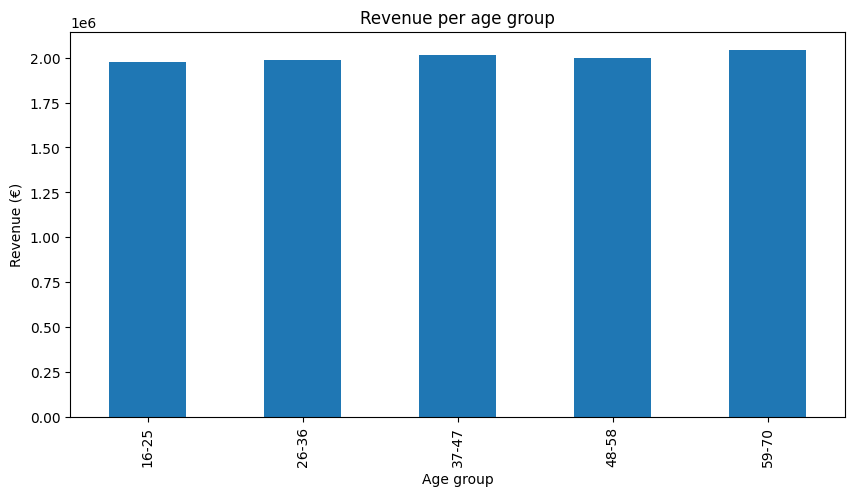

Age group with highest revenue (€):
age_group
59-70    2.043404e+06
37-47    2.012787e+06
48-58    2.000752e+06
26-36    1.989009e+06
16-25    1.975149e+06
Name: sale_price, dtype: float64

Age group with lowest revenue (€):
age_group
16-25    1.975149e+06
26-36    1.989009e+06
48-58    2.000752e+06
37-47    2.012787e+06
59-70    2.043404e+06
Name: sale_price, dtype: float64


In [42]:
#revenue per age group
rev_age_group = df_order_status_user.groupby('age_group', observed=True)['sale_price'].sum()

rev_age_group.plot(kind='bar', figsize=(10,5))
plt.title("Revenue per age group")
plt.xlabel("Age group")
plt.ylabel("Revenue (€)")
plt.show()

print("Age group with highest revenue (€):")
print(rev_age_group.sort_values(ascending=False).head())

print("\nAge group with lowest revenue (€):")
print(rev_age_group.sort_values(ascending=True).head())

**Average Order Value (AOV)**

In [43]:
#Average Order Value (AOV)
revenue_per_order = df_order_status_user.groupby('order_id')['sale_price'].sum() 

AOV = revenue_per_order.mean()
print ("AOV per order:",AOV.round(2),"€")

AOV per order: 86.07 €


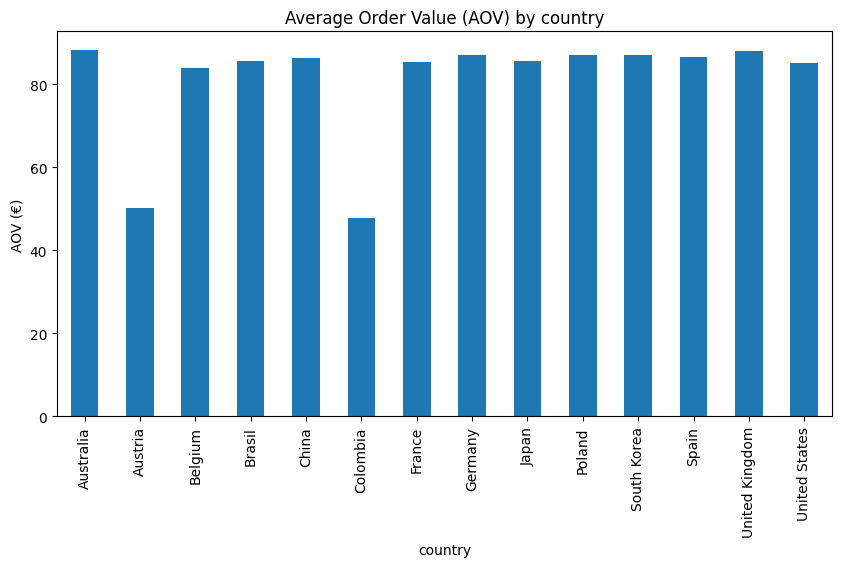

Country with highest AOV (€):
country
Australia         88.311254
United Kingdom    88.058887
Germany           87.125787
South Korea       87.114650
Poland            87.000139
dtype: float64

Country with lowest AOV (€):
country
Colombia         47.868572
Austria          50.084000
Belgium          83.994174
United States    85.055018
France           85.255266
dtype: float64


In [44]:
#AOV per country
AOV_by_country = (
    df_order_status_user.groupby('country')['sale_price'].sum() /
    df_order_status_user.groupby('country')['order_id'].nunique())

(AOV_by_country).plot(kind='bar', figsize=(10,5))
plt.title("Average Order Value (AOV) by country")
plt.xlabel("country")
plt.ylabel("AOV (€)")
plt.show()

print("Country with highest AOV (€):")
print((AOV_by_country).sort_values(ascending=False).head())
print("\nCountry with lowest AOV (€):")
print((AOV_by_country).sort_values(ascending=True).head())

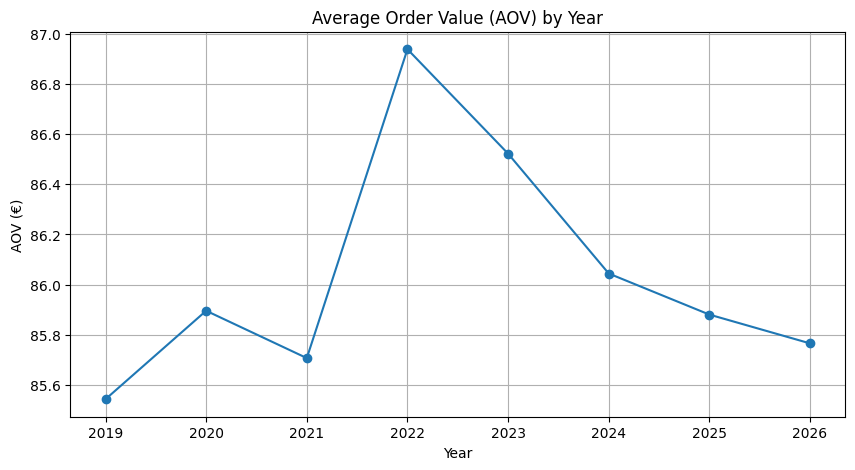

year
2019    85.54
2020    85.90
2021    85.71
2022    86.94
2023    86.52
2024    86.04
2025    85.88
2026    85.77
dtype: float64


In [45]:
#AOV per year
df_order_status_user['year'] = df_order_status_user['order_created_at'].dt.year

AOV_by_year = df_order_status_user.groupby('year')['sale_price'].sum() / df_order_status_user.groupby('year')['order_id'].nunique()
              
plt.figure(figsize=(10,5))
plt.plot(AOV_by_year.index, AOV_by_year.values, marker='o')
plt.title("Average Order Value (AOV) by Year")
plt.xlabel("Year")
plt.ylabel("AOV (€)")
plt.grid(True)
plt.show()

print(AOV_by_year.round(2))

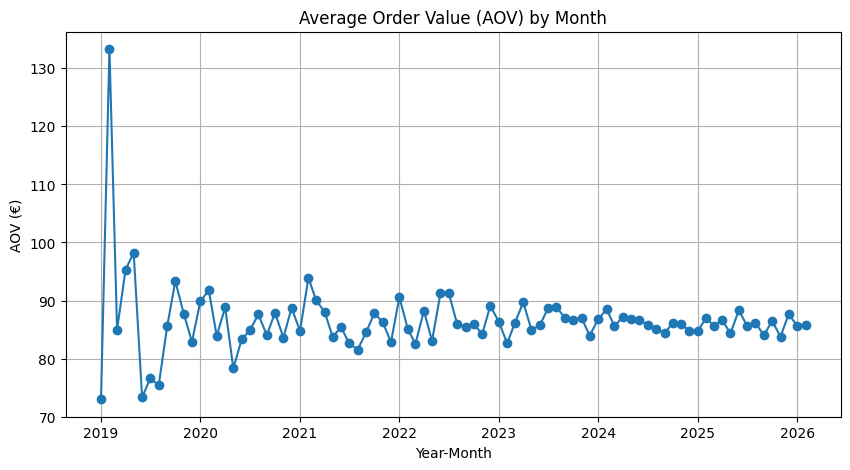

In [46]:
#AOV per month
df_order_status_user['year_month'] = df_order_status_user['order_created_at'].dt.to_period('M')

AOV_by_month = df_order_status_user.groupby('year_month')['sale_price'].sum() / \
               df_order_status_user.groupby('year_month')['order_id'].nunique()
               
plt.figure(figsize=(10,5))
plt.plot(AOV_by_month.index.to_timestamp(), AOV_by_month.values, marker='o')
plt.title("Average Order Value (AOV) by Month")
plt.xlabel("Year-Month")
plt.ylabel("AOV (€)")
plt.grid(True)
plt.show()

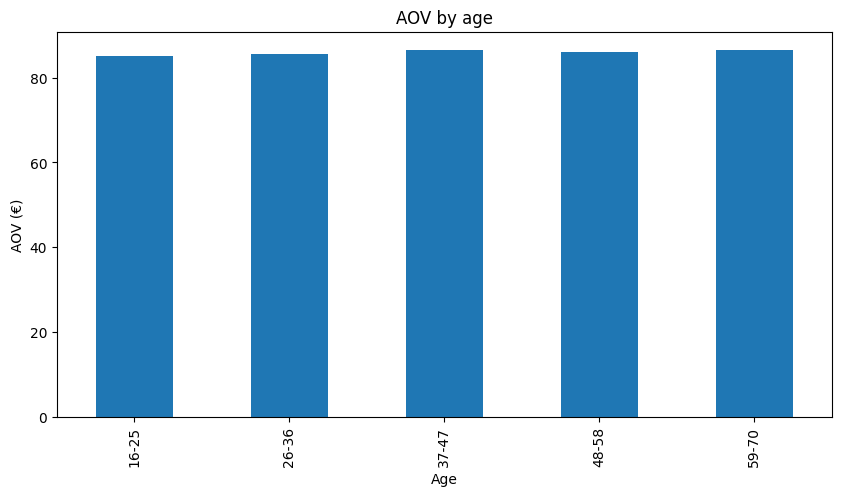

AOV by age (€):
age_group
16-25    85.13
26-36    85.60
37-47    86.58
48-58    86.12
59-70    86.58
Name: sale_price, dtype: float64


In [47]:
#AOV per age
AOV_by_age = (df_order_status_user.groupby(['age_group', 'order_id'], observed=True)['sale_price']
                .sum().groupby('age_group', observed=True).mean().round(2))

AOV_by_age.plot(kind='bar', figsize=(10,5))
plt.title("AOV by age")
plt.xlabel("Age")
plt.ylabel("AOV (€)")
plt.show()

print("AOV by age (€):")
print(AOV_by_age)

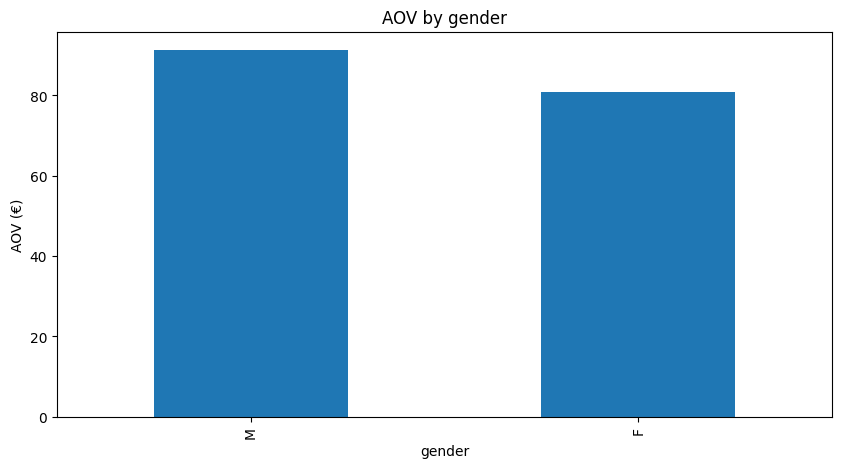

AOV per gender (€):
gender
M    91.31
F    80.85
Name: sale_price, dtype: float64


In [48]:
#AOV per gender
AOV_by_gender=AOV_by_gender = (df_order_status_user.groupby(['gender', 'order_id'], observed=True)['sale_price'].sum()   
    .groupby('gender', observed=True).mean().round(2).sort_values(ascending=False))

AOV_by_gender.plot(kind='bar', figsize=(10,5))
plt.title("AOV by gender")
plt.xlabel("gender")
plt.ylabel("AOV (€)")
plt.show()

print("AOV per gender (€):")
print(AOV_by_gender)

**Cancellation rate statistic**

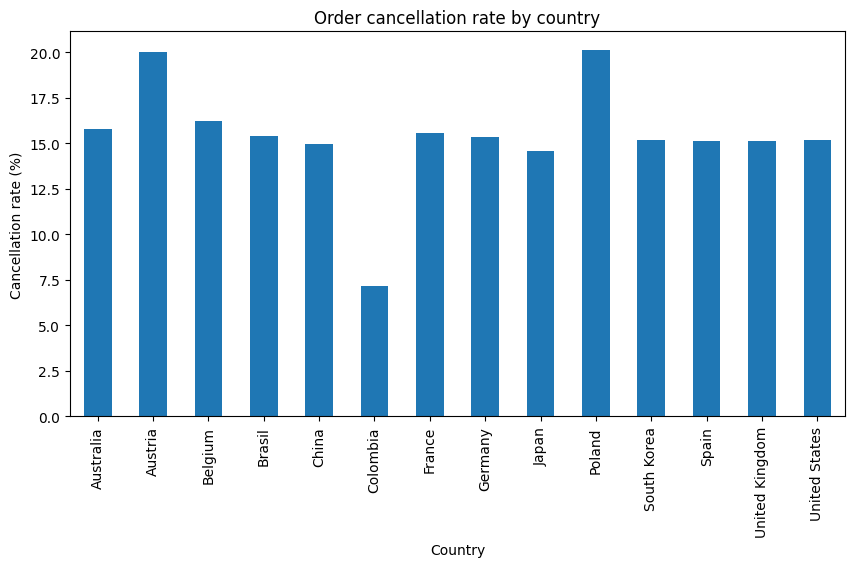

Country with highest cancellation rate:
country
Colombia      7.14%
Poland       20.14%
Austria      20.00%
Belgium      16.25%
Australia    15.79%
Name: order_status, dtype: object

Country with lowest cancellation rate:
country
Japan             14.56%
China             14.93%
United Kingdom    15.11%
Spain             15.13%
United States     15.15%
Name: order_status, dtype: object


In [49]:
#cancel_by_country
cancel_by_country = df_order_status_user2.groupby('country')['order_status'].apply(lambda x: (x=='Cancelled').mean())

(cancel_by_country * 100).plot(kind='bar', figsize=(10,5))
plt.title("Order cancellation rate by country")
plt.xlabel("Country")
plt.ylabel("Cancellation rate (%)")
plt.show()

print("Country with highest cancellation rate:")
print((cancel_by_country * 100).apply(lambda x: f"{x:.2f}%").sort_values(ascending=False).head())
print("\nCountry with lowest cancellation rate:")
print((cancel_by_country * 100).apply(lambda x: f"{x:.2f}%").sort_values(ascending=True).head())


Cancellation Rate by Gender:
gender
F    15.22%
M    15.12%
Name: order_status, dtype: object


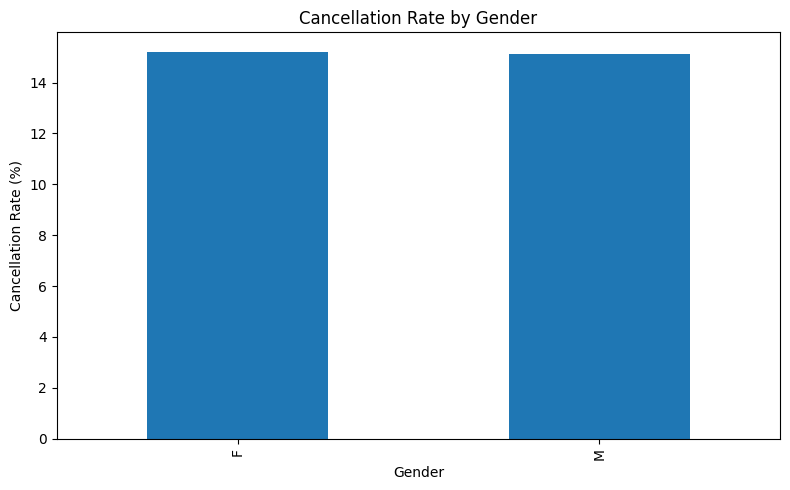

In [50]:
#cancel_by_gender
cancel_by_gender = (df_order_status_user2.groupby('gender')['order_status'].apply(lambda x: (x == 'Cancelled').mean())
)

print("Cancellation Rate by Gender:")
print((cancel_by_gender * 100).round(2).astype(str) + "%")

# Plot
(cancel_by_gender * 100).plot(kind='bar', figsize=(8,5))

plt.title("Cancellation Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Cancellation Rate (%)")
plt.tight_layout()
plt.show()

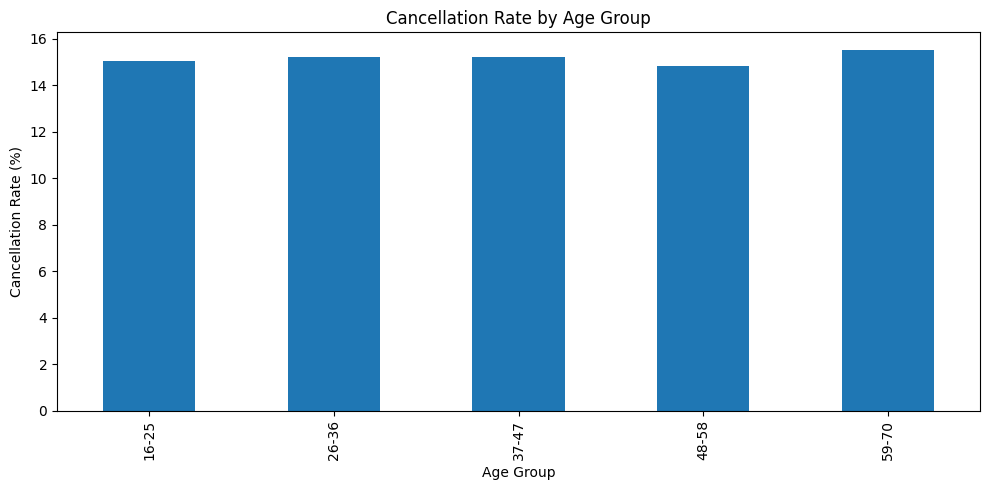

Age with highest cancellation rate:
age_group
59-70     15.5%
37-47    15.22%
26-36    15.21%
16-25    15.05%
48-58    14.84%
Name: order_status, dtype: object

Age with lowest cancellation rate:
age_group
48-58    14.84%
16-25    15.05%
26-36    15.21%
37-47    15.22%
59-70     15.5%
Name: order_status, dtype: object


In [51]:
# Cancellation rate by age group
cancel_by_age = (df_order_status_user2.groupby('age_group', observed=True)['order_status'].apply(lambda x: (x == 'Cancelled').mean()))


(cancel_by_age * 100).plot(kind='bar', figsize=(10,5))
plt.title("Cancellation Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Cancellation Rate (%)")
plt.tight_layout()
plt.show()

print("Age with highest cancellation rate:")
print((cancel_by_age * 100).round(2).sort_values(ascending=False).head().astype(str) + "%")
print("\nAge with lowest cancellation rate:")
print((cancel_by_age * 100).round(2).sort_values(ascending=True).head().astype(str) + "%")

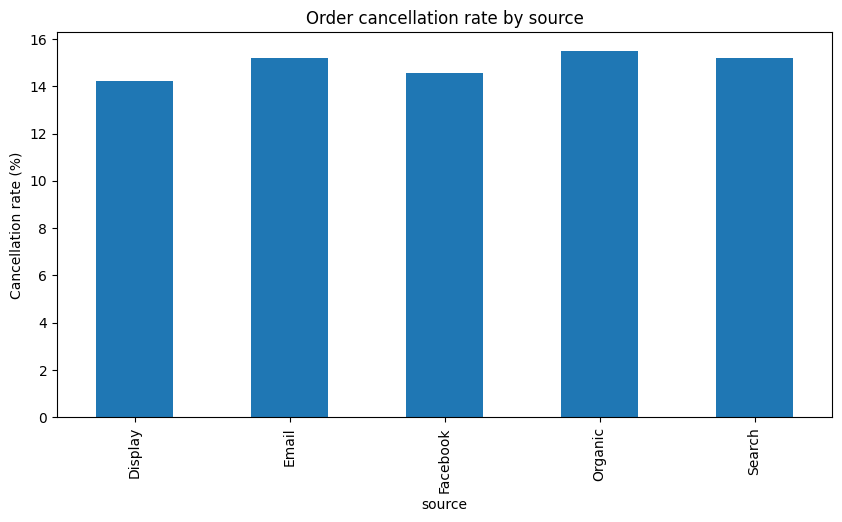

Source with highest cancellation rate:
traffic_source
Organic     15.51%
Email       15.21%
Search      15.20%
Facebook    14.55%
Display     14.23%
Name: order_status, dtype: object


In [52]:
#Plot cancellation rate (%) by traffic source
cancel_by_source= df_order_status_user2.groupby('traffic_source')['order_status'].apply(lambda x: (x=='Cancelled').mean())

(cancel_by_source * 100).plot(kind='bar', figsize=(10,5))
plt.title("Order cancellation rate by source")
plt.xlabel("source")
plt.ylabel("Cancellation rate (%)")
plt.show()

print("Source with highest cancellation rate:")
print((cancel_by_source * 100).apply(lambda x: f"{x:.2f}%").sort_values(ascending=False).head())

The typical customer mainly comes from China or the United States, lives in large, high‑density urban areas, and makes 1–2 purchases per year on average.
The purchasing behavior is balanced across genders, with no meaningful differences between men and women.
Customer loyalty is remarkably strong: around 37% of users make more than one purchase per year, a rate significantly higher than standard e‑commerce benchmarks.

Revenue follows a pattern that can be accurately modeled with an exponential growth curve, while the Average Order Value (AOV) remains essentially stable over time.

Paid traffic (Facebook, Email, Display) accounts for roughly 15% of total traffic, a share comparable to Organic.
This proportion suggests that paid campaigns are not generating a substantial incremental lift in customer acquisition beyond what would occur organically.
To properly assess the real contribution of paid media, it is necessary to integrate advertising costs and compute metrics such as:ROI (Return on Investment) and ROAS (Return on Ad Spend). Only then can we determine whether paid traffic generates a positive net return compared to its cost.

Austria and Colombia show a significantly lower AOV than other markets.
However, this is not a structural market behavior because they have an extremely low order volumes (7 orders in Austria, 20 in Colombia), purchases concentrated almost exclusively on low‑ticket products and insufficient data to draw reliable conclusions. The low AOV it is therefore to consider as a statistical artifact, not a market signal.

Austriaand shows a high cancellation rate, but the sample size is too small to be meaningful.
Colombia shows an unusually low cancellation rate for the same reason.
Poland has a higher cancellation rate due to a cheaper product mix: low‑ticket items tend to be more impulsive and therefore more frequently cancelled.
In all other countries, cancellation rates are stable and consistent with typical e‑commerce dynamics.

Overall, the brand is in a strong position: the customer base is healthy, revenue follows a clear exponential growth pattern, and loyalty levels are well above industry standards.
At the same time, there is meaningful room for improvement — particularly in marketing efficiency and market penetration — which could further enhance both profitability and operational performance.
